# SQL vs NoSql vs NewSql

This notebook is used to run code and generate graphs

### Imports

In [1]:
import subprocess
import os
import time
import postgres_import as pos_i
import mysql_import as my_i
import memsql_import as mem_i

### Helper function to generate a bar plot graph

In [47]:
import numpy as np
from matplotlib import pyplot as plt

def bar_plot(data, items, colours, title):
    fig = plt.figure()

    width = .45
    ind = np.arange(len(data))
    
    plt.bar(0.3+ind, import_times_avg, width=width, color=colours)
    plt.xticks(0.3+ind + width / 2, items)
    plt.title(title)

    fig.autofmt_xdate()

    plt.show()

### Helper function to run commands inside a shell

In [2]:
def run_command(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

def run_command2(command, verbose=True, save_mem=False):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    returncode = process.wait()
    output = ""
    if not(save_mem):
        output = process.stdout.read().decode('utf-8', 'replace').replace("\r", "").split("\n")
        if verbose: 
            for line in output:
                print (line)
    return output

## Starting all the docker containers to check if it's all right

In [3]:
o = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d')

neo4j is up-to-date
Creating nuodb
Creating cockroach
Creating redis
Creating mysql
Creating cassandra
Creating trafodion
Creating voltdb
Creating mongo
Creating postgres
Creating orientdb
Creating memsql



We will need the local ip of the Coackroach container for later use.

In [5]:
ip = run_command('docker exec cockroach ip route', verbose=False)
ip = ip[len(ip)-2].split(" ")
ip = ip[len(ip)-2]
coackroach_ip = ip
print(coackroach_ip)

172.18.0.4


## Stopping all the containers
Test functions will start and stop the containers many times in order to accurately measure times.

In [4]:
o = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down')

## Definitions

In [52]:
postgres_container = "postgres"
containers = ["mongo", "redis", "neo4j", "orientdb", "cassandra", postgres_container, "mysql", "memsql", "voltdb", "cockroach"]
colours = ["lightgreen", "red", "deepskyblue", "orange", "skyblue", "lightsteelblue", "steelblue", "cornflowerblue", "firebrick", "darkgreen"]

### Helper functions to run tests and measure the time taken

In [7]:
def exec_and_time(container, command, verbose=True, save_mem=False):
    start = time.time()
    if container == postgres_container or container == "mysql" or container == "memsql":
        command[0](os.path.join(os.path.abspath('./Docker/shared_data'),command[1]))
    elif container == "cockroach":
        o = run_command('docker exec --privileged ' + container + ' sh -c "' + command[0] + '"', verbose, save_mem)
        o = run_command('docker exec --privileged --user postgres '+ postgres_container +' sh -c "' + command[1] + '"', verbose, save_mem)
    elif container == "cassandra":
        o = run_command2('docker exec --privileged ' + container + ' '+ command[0] +' -c "' + command[1] + '"', verbose, save_mem)
    else: 
        o = run_command('docker exec --privileged ' + container + ' sh -c "' + command + '"', verbose, save_mem)
    end = time.time()
    return end - start

In [26]:
def average_time(commands, containers, iterations, verbose=True, import_data=False):
    times = [0] * len(containers)
    peak_times = [0] * len(containers)
    for j in range(0, iterations):
        if verbose:
            print("iteration " + str(j+1))
        o = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose up -d', verbose=False)
        if verbose:
            print("waiting...")
        time.sleep(25) 
        for i in range(0, len(containers)):
            if verbose:
                print(containers[i])
            if import_data:
                exec_and_time(containers[i], data_import_commands[i], verbose=False, save_mem=True)
            time_taken = exec_and_time(containers[i], commands[i], verbose=False, save_mem=True)
            times[i] += time_taken
            if peak_times[i] < time_taken:
                peak_times[i] = time_taken
        o = run_command('D: && cd "D:\GitHub\BigData\Project2\Docker" && docker-compose down', verbose=False)
    for i in range(0, len(containers)):
        times[i] = times[i]/iterations
        print(containers[i] + ": " + str(times[i]))
    return (times, peak_times)

## Average bulk import time

### Import commands

In [6]:
data_import_commands = [
    "mongoimport --db testing_db --collection customers --type csv --headerline --file /shared_data/mock_data_10000_rows.csv",
    "cat /shared_data/mock_data_10000_rows2.csv | redis-cli --pipe",
    "cp /shared_data/mock_data_10000_neo.csv /var/lib/neo4j/import && cat /shared_scripts/import_mock_10000.cypher | /var/lib/neo4j/bin/cypher-shell",
    "/orientdb/bin/oetl.sh /shared_scripts/import_orient_10000.json",
    ["bash", "cqlsh -f /shared_scripts/import_mock_10000.cql"],
    [pos_i.sql_import, "mock_data_10000_rows_utf8.csv"], #postgres
    [my_i.sql_import, "mock_data_10000_rows_utf8.csv"], #mysql
    [mem_i.sql_import, "mock_data_10000_rows_utf8.csv"], #memsql
    "cat /shared_scripts/import_voltdb.sql | sqlcmd && /opt/voltdb/bin/csvloader customers -f /shared_data/mock_data_10000_rows.csv",
    ["./cockroach sql --insecure --execute='create database if not exists mock;'", "psql -p 26257 -h '+ coackroach_ip +' -d mock -U root < /shared_data/postgres_dump.sql"]
]

#### Iterating

In [27]:
(import_times_avg, import_times_peak) = average_time(data_import_commands, containers, 5)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 2
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 1.1958986520767212
redis: 0.347528338432312
neo4j: 6.366888523101807
orientdb: 16.949461340904236
cassandra: 5.604731321334839
postgres: 4.522922515869141
mysql: 1.4159133434295654
memsql: 4.252250552177429
voltdb: 4.944749474525452
cockroach: 0.9271417856216431


### Results

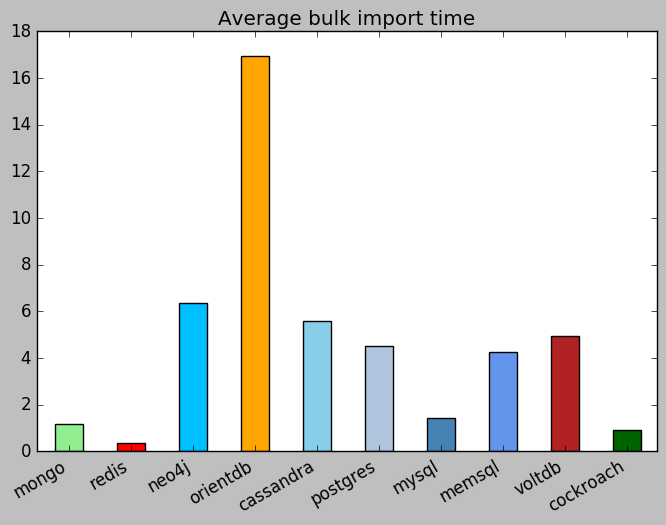

In [50]:
bar_plot(import_times_avg, containers, colours, "Average bulk import time")

## Query execution time and throughput

### Commands

In [6]:
data_import_commands = [
    "mongoimport --db testing_db --collection customers --type csv --headerline --file /shared_data/mock_data_10000_rows.csv",
    "cat /shared_data/mock_data_10000_rows2.csv | redis-cli --pipe",
    "cp /shared_data/mock_data_10000_neo.csv /var/lib/neo4j/import && cat /shared_scripts/import_mock_10000.cypher | /var/lib/neo4j/bin/cypher-shell",
    "/orientdb/bin/oetl.sh /shared_scripts/import_orient_10000.json",
    ["bash", "cqlsh -f /shared_scripts/import_mock_10000.cql"],
    [pos_i.sql_import, "mock_data_10000_rows_utf8.csv"], #postgres
    [my_i.sql_import, "mock_data_10000_rows_utf8.csv"], #mysql
    [mem_i.sql_import, "mock_data_10000_rows_utf8.csv"], #memsql
    "cat /shared_scripts/import_voltdb.sql | sqlcmd && /opt/voltdb/bin/csvloader customers -f /shared_data/mock_data_10000_rows.csv",
    ["./cockroach sql --insecure --execute='create database if not exists mock;'", "psql -p 26257 -h '+ coackroach_ip +' -d mock -U root < /shared_data/postgres_dump.sql"]
]

#### Iterating

In [27]:
(import_times_avg, import_times_peak) = average_time(data_import_commands, containers, 5)

iteration 1
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
iteration 2
waiting...
mongo
redis
neo4j
orientdb
cassandra
postgres
mysql
memsql
voltdb
cockroach
mongo: 1.1958986520767212
redis: 0.347528338432312
neo4j: 6.366888523101807
orientdb: 16.949461340904236
cassandra: 5.604731321334839
postgres: 4.522922515869141
mysql: 1.4159133434295654
memsql: 4.252250552177429
voltdb: 4.944749474525452
cockroach: 0.9271417856216431


### Results

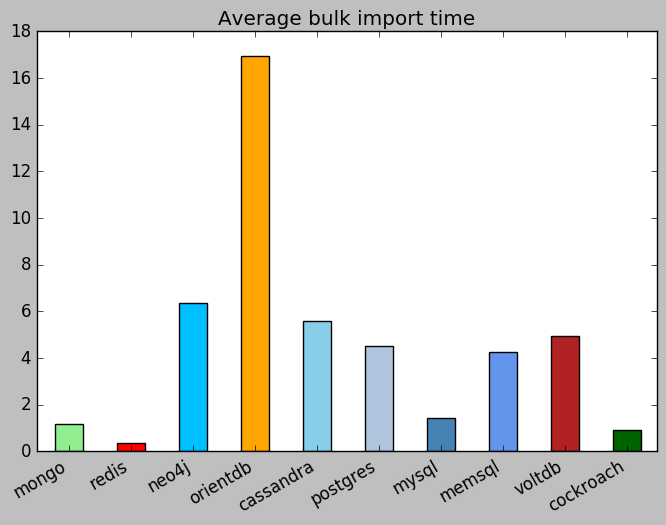

In [50]:
bar_plot(import_times_avg, containers, colours, "Average bulk import time")